# **Practicum 2 - Visual Question Answering**
### **Team Anonymous**


In [ ]:
!pip install transformers #Installing Huggingface transformers 

     |████████████████████████████████| 1.3MB 14.2MB/s 
     |████████████████████████████████| 1.1MB 53.6MB/s 
     |████████████████████████████████| 890kB 24.3MB/s 
     |████████████████████████████████| 2.9MB 35.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ee0586cd745eaeb70ed395b7b312748e10d7c2400af557fda478b03e10b0a337
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install -q tensorflow_model_optimization

     |████████████████████████████████| 174kB 13.9MB/s 


In [ ]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import subprocess
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude
from keras.utils.layer_utils import count_params
import tensorflow_hub as hub
from collections import Counter
from transformers import TFBertModel, TFDistilBertModel
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, TFDistilBertForSequenceClassification

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.3.0
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Tue Nov 17 04:53:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |    359MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Utils

In [ ]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

# we use the following to save the models
class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

# save_model saves everything. weights, statuses and results. 
def save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results,path="/content/gdrive/My Drive/models"):
  model_name=model.name
  # Get the model train history
  model_train_history = training_results.history

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)
  # Save the enitire model (structure + weights)
  #model.save(os.path.join(path,model_name+".hdf5"))
  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  '''
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)
  '''
    
  #model_size = get_model_size(model_name=model_name)

  # Save model history
  with open(os.path.join(path,model_name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)
  total_params = trainable_parameters + non_trainable_parameters

  # Save model metrics
  metrics ={
      "total_params":total_params,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "learning_rate":learning_rate,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "name": model_name,
      "id": int(time.time())
  }

  with open(os.path.join(path,model.name+"_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_model(model,test_data, training_results,execution_time, learning_rate, epochs, 
                   optimizer,save=True, 
                   loss_metrics=["loss","val_loss"],
                   acc_metrics=["accuracy","val_accuracy"]):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  
  if save:
      # Save model
      save_model(model,training_results,execution_time, learning_rate, epochs, optimizer, evaluation_results)
  
  return evaluation_results
def get_dataset_size(base_path):
  dataset_folder_size = subprocess.check_output(['du','-sh', base_path]).split()[0].decode('utf-8')
  print("Dataset size on disk:")
  print("----------------")
  print("Total Size: ",dataset_folder_size)
  dataset_folder_size = dataset_folder_size.replace("G","000000000")
  dataset_folder_size = float(dataset_folder_size)

  dataset_file_list = glob(base_path+'/*')
  dataset_download_size = 0.0
  for file in dataset_file_list:
    if file.endswith(".zip"):
      dataset_download_size += os.path.getsize(file)

  dataset_download_size = dataset_download_size/1000000000
  dataset_size = dataset_folder_size - dataset_download_size

  print("Download Size: ",str(dataset_download_size)+"G")
  print("Dataset Size: ",str(dataset_size)+"G")

def get_dataset_list(base_path):
  # Labels
  label_names = os.listdir(base_path)

  # Generate a list of labels and path to images
  data_list = []
  for label in label_names:
      # Images
      image_files = os.listdir(os.path.join(base_path,label))
      data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

  return label_names, data_list

### Download and Read Data

In [ ]:
train_image="https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/train2014.zip"
train_question="https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Train_mscoco.zip"
train_answer="https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip"
val_image="https://storage.googleapis.com/ac295-data-store/visualqa_2017_small/val2014.zip"
val_question="https://public-dataset-store.s3.amazonaws.com/visualqa_2017/v2_Questions_Val_mscoco.zip"
val_answer="https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip"
start_time = time.time()
download_file(train_image, base_path="images", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)
start_time = time.time()
download_file(val_image, base_path="images", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 1.0884111642837524
Download execution time (mins) 0.702152955532074


In [ ]:
start_time = time.time()
download_file(train_question, base_path="question_answer", extract=True)
download_file(train_answer, base_path="question_answer", extract=True)
download_file(val_question, base_path="question_answer", extract=True)
download_file(val_answer, base_path="question_answer", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.24153080781300862


In [ ]:
# Read data from json file
with open('question_answer/v2_OpenEnded_mscoco_train2014_questions.json') as f:
  train_question=json.load(f)
train_data=pd.DataFrame.from_dict(train_question['questions'])
with open('question_answer/v2_mscoco_train2014_annotations.json') as f:
  train_answer=json.load(f)
train_answer=pd.DataFrame(train_answer['annotations'])
with open('question_answer/v2_OpenEnded_mscoco_val2014_questions.json') as f:
  val_question=json.load(f)
val_data=pd.DataFrame.from_dict(val_question['questions'])
with open('question_answer/v2_mscoco_val2014_annotations.json') as f:
  val_answer=json.load(f)
val_answer=pd.DataFrame(val_answer['annotations'])

### Data Pre-Processing

In [ ]:
#Merge question and answer
train_data=pd.merge(train_data,train_answer[['multiple_choice_answer','question_id']],how='left',on='question_id')
train_data.drop(columns=['question_id'],inplace=True)
val_data=pd.merge(val_data,val_answer[['multiple_choice_answer','question_id']],how='left',on='question_id')
val_data.drop(columns=['question_id'],inplace=True)

In [ ]:
#Find top 10 most common answers,can speicify number of answers
number_of_answer=10
counter=Counter(list(train_data.multiple_choice_answer.values)+list(val_data.multiple_choice_answer.values))
top10_answers=[]
for i in counter.most_common(number_of_answer):
  top10_answers.append(i[0])

In [ ]:
#label2index,index2label
label2index = dict((name, index) for index, name in enumerate(top10_answers))
index2label = dict((index, name) for index, name in enumerate(top10_answers))

In [ ]:
#Only pick questions have the most common answers
train_data=train_data[train_data.multiple_choice_answer.isin(top10_answers)]
val_data=val_data[val_data.multiple_choice_answer.isin(top10_answers)]

In [ ]:
#Build dataset
train_image=train_data.image_id.values
train_question=train_data.question.values
train_y=train_data.multiple_choice_answer.values
val_image=val_data.image_id.values
val_question=val_data.question.values
val_y=val_data.multiple_choice_answer.values
train_image=['images/train2014/COCO_train2014_'+'0'*(12-len(str(i)))+str(i)+'.jpg' for i in train_image]
val_image=[f'images/val2014/COCO_val2014_'+'0'*(12-len(str(i)))+str(i)+'.jpg' for i in val_image]
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_width = 224
image_height = 224
num_channels = 3
num_classes = len(top10_answers) 
batch_size = 32
shuffle_buffer_size=3000 # For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
train_processed_y = [label2index[label] for label in train_y]
val_processed_y = [label2index[label] for label in val_y]


In [ ]:
#Get Bert encoding
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
max_length=max(len(max(train_question,key=len)),len(max(val_question,key=len)))
train_x=tokenizer.batch_encode_plus(
        train_question,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=max_length, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )
validate_x=tokenizer.batch_encode_plus(
        val_question,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=max_length, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )
num_vocab = tokenizer.vocab_size

## Loading data without TFrecords

In [ ]:
#mapping function
#load and normalize image
def load_normalize_train_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  #normlize pixel
  image = image/255
  return image
#built desired input format
def processing_input(image_path,input_ids,token_type_ids,attention_mask,label):
  image=load_normalize_train_image(image_path)
  return ((image,{'input_ids':input_ids,
          'token_type_ids':token_type_ids,
            'attention_mask':attention_mask}),label)

In [ ]:
#Specify parameters
batch_size = 64 # You can try higher values but may run into OOM errors depending on which GPU you are using
train_shuffle_buffer_size = 800
validation_shuffle_buffer_size = 200
#Build train dataset
train_data=tf.data.Dataset.from_tensor_slices((train_image,train_x['input_ids'],train_x['token_type_ids'],train_x['attention_mask'],train_processed_y))
train_data=train_data.map(processing_input, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
#Build validation dataset
validation_data=tf.data.Dataset.from_tensor_slices((val_image,validate_x['input_ids'],validate_x['token_type_ids'],validate_x['attention_mask'],val_processed_y))
validation_data =validation_data.map(processing_input, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=train_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
print("train_data",train_data)
print("validation_data",validation_data)

train_data <BatchDataset shapes: (((None, 224, 224, 3), {input_ids: (None, 100), token_type_ids: (None, 100), attention_mask: (None, 100)}), (None,)), types: ((tf.float32, {input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}), tf.int32)>
validation_data <BatchDataset shapes: (((None, 224, 224, 3), {input_ids: (None, 100), token_type_ids: (None, 100), attention_mask: (None, 100)}), (None,)), types: ((tf.float32, {input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}), tf.int32)>


## **Final Visual Question Answering Model**

*pre-trained Bert + mobilenetv2*

In [ ]:

K.clear_session()
learning_rate=0.001
## QA Model
max_len = 100
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'input_ids')
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'token_type_ids')
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name = 'attention_mask')
image_input = layers.Input(shape=[224,224,3], name='image_input')

#question model: BERT
encoder = TFBertModel.from_pretrained("bert-base-uncased")
encoder.trainable=False
embedding = encoder(
    input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
)[1]
embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
text_dropout=layers.Dropout(0.2)(embedding_flatten)
bert_dense = layers.Dense(256, name="bert_dense")(text_dropout)


#image model: mobilenet
mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet')
mobilenetv2.trainable=False
image_flat = layers.Flatten(name = 'image_flat')(mobilenetv2(image_input))
image_dropout=layers.Dropout(0.2)(image_flat)
#image_flat = Flatten()(model.layers[-1].output)(image_pretrained)
image_dense = layers.Dense(256, activation='relu')(image_dropout)

#image + question
image_question = layers.Multiply()([image_dense, bert_dense])                          
image_question_dense_1 = layers.Dense(units=32, name = 'image_question_dense_1')(image_question)
classifier = layers.Dense(units= 10, name = 'classifier')(image_question_dense_1)


inputs = (image_input, {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})

model = keras.Model(inputs= inputs, outputs= classifier,name='Vqa_model_dropout')

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate, epsilon=1e-08)

# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.SparseCategoricalAccuracy()])

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "Vqa_model_dropout"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________

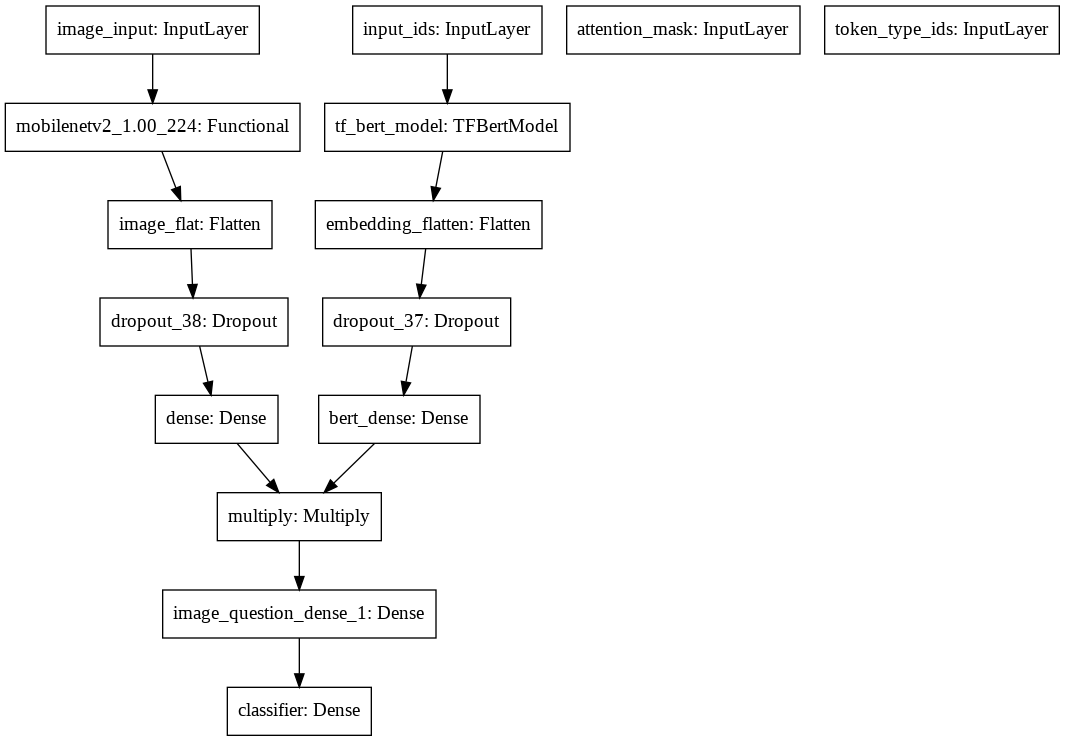

In [ ]:
plot_model(model, to_file='plot_model.png', show_shapes=False, show_layer_names=True)

Epoch 1/10
3569/3569 [==============================] - 1565s 438ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.4225 - val_loss: 0.9166 - val_sparse_categorical_accuracy: 0.4501
Epoch 2/10
3569/3569 [==============================] - 1561s 437ms/step - loss: 1.0619 - sparse_categorical_accuracy: 0.4380 - val_loss: 0.9221 - val_sparse_categorical_accuracy: 0.4623
Epoch 3/10
3569/3569 [==============================] - 1560s 437ms/step - loss: 1.0534 - sparse_categorical_accuracy: 0.4376 - val_loss: 0.9145 - val_sparse_categorical_accuracy: 0.4576
Epoch 4/10
3569/3569 [==============================] - 1558s 437ms/step - loss: 1.0384 - sparse_categorical_accuracy: 0.4375 - val_loss: 0.9239 - val_sparse_categorical_accuracy: 0.4536
Epoch 5/10
3569/3569 [==============================] - 1552s 435ms/step - loss: 1.0326 - sparse_categorical_accuracy: 0.4388 - val_loss: 0.9041 - val_sparse_categorical_accuracy: 0.4526
Epoch 6/10
3569/3569 [==============================] - 1548s 434

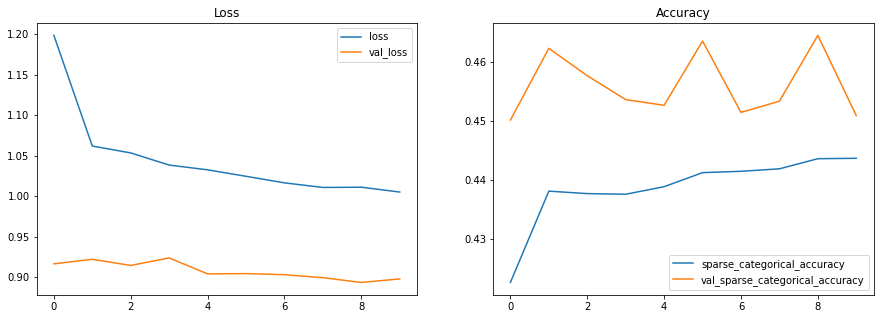

1721/1721 [==============================] - 561s 326ms/step - loss: 0.8969 - sparse_categorical_accuracy: 0.4532
{'loss': 0.8969497084617615, 'sparse_categorical_accuracy': 0.45315423607826233}


[0.8969497084617615, 0.45315423607826233]

In [ ]:
epochs=10
start_time = time.time()
training_results=model.fit( train_data, validation_data = validation_data.take(1000), epochs=epochs, verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)
evaluate_model(model,validation_data, training_results,execution_time, 
               learning_rate, epochs, optimizer,save=False,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

### Load VQA Model Weights and Performance Evaluation

Note: the validation accuracy in the plot above is only evaluated on 1000 batches in order to speed up the training process, the performance printed below is evaluated on the full validation data, which is 47.1%.

In [ ]:
weights_path= "/content/gdrive/My Drive/models/Vqa_model_test.h5"
#weights_path="./Vqa_model_test.h5'"
K.clear_session()
learning_rate=0.001
## QA Model
max_len = 100
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
image_input = layers.Input(shape=[224,224,3], name='image_input')

#question model: BERT
encoder = TFBertModel.from_pretrained("bert-base-uncased")
encoder.trainable=False
embedding = encoder(
    input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
)[1]
embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
bert_dense = layers.Dense(256, name="bert_dense")(embedding_flatten)


#image model: mobilenet
mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet')
mobilenetv2.trainable=False
image_flat = layers.Flatten()(mobilenetv2(image_input))
#image_flat = Flatten()(model.layers[-1].output)(image_pretrained)
image_dense = layers.Dense(256, activation='relu')(image_flat)

#image + question
image_question = layers.Multiply()([bert_dense, image_dense])                          
image_question_dense_1 = layers.Dense(units=32, name = 'image_question_dense_1')(image_question)
classifier = layers.Dense(units= 10, name = 'classifier')(image_question_dense_1)


inputs = (image_input, {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})

model = keras.Model(inputs= inputs, outputs= classifier,name='Vqa_model_test')
model.load_weights(weights_path)

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate, epsilon=1e-08)

# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics.SparseCategoricalAccuracy()])

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


9412608/9406464 [==============================] - 0s 0us/step
Model: "Vqa_model_test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
______________________

In [ ]:
model.evaluate(validation_data, return_dict=True)

1721/1721 [==============================] - 562s 326ms/step - loss: 0.9013 - sparse_categorical_accuracy: 0.4712


{'loss': 0.9013293385505676,
 'sparse_categorical_accuracy': 0.47118231654167175}

In [ ]:
teacher_model = model

## **Model Distillation**

In [ ]:
# Student Model
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels
  model_name =  model_name +"_"+ str(int(time.time()))

  input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
  token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
  attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
  image_input = layers.Input(shape=[224,224,3], name='image_input')
  
  # Text model: LSTM
  embedded_question = layers.Embedding(input_dim=num_vocab + 1, output_dim=256, input_length=100)(input_ids)
  encoded_question = layers.LSTM(256)(embedded_question)
  
  #Image model: Simple CNN
  conv1 = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same")(image_input)
  conv1 = layers.LeakyReLU(alpha=0.2)(conv1)
  maxpool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(conv1)
  conv2 = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same")(conv1)
  maxpool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(conv2)
  image_flattened = layers.Flatten()(maxpool2)
  image_dense = layers.Dense(256, name="image_dense", activation='relu')(image_flattened)

  image_question = layers.Multiply()([encoded_question, image_dense])                          
  image_question_dense_1 = layers.Dense(units=32, name = 'image_question_dense_1')(image_question)
  classifier = layers.Dense(units= 10, name = 'classifier')(image_question_dense_1)


  inputs = (image_input, {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})

  model = keras.Model(inputs= inputs, outputs= classifier,name=model_name)    
  return model

In [ ]:
# Distillation
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,distillation_loss_fn,alpha=0.1,temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.alpha = alpha
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
alphas=[0.1,0.2,0.3,0.5,1.0]
temperatures=[1,5,10,15,30]
alpha = 0.9
temperature = 15
# Free up memory
K.clear_session()

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate)
# Loss
student_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
distillation_loss = tf.keras.losses.KLDivergence()

In [ ]:
# Hyperparameter tuning
for a in alphas:
  student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')
  #print(student_model.summary())
  # Build the distiller model
  distiller_model = Distiller(teacher=teacher_model, student=student_model)
  # Compile
  distiller_model.compile(
      optimizer=optimizer,
      student_loss_fn=student_loss,
      distillation_loss_fn=distillation_loss,
      metrics=[metrics.SparseCategoricalAccuracy()],
      alpha=a,
      temperature=temperature
  )

  # Distill teacher to student
  start_time = time.time()
  training_results = distiller_model.fit(
          train_data.take(1000),
          validation_data=validation_data.take(500),
          epochs=3, 
          verbose=1)
  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)

for t in alphas:
  student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')
  #print(student_model.summary())
  # Build the distiller model
  distiller_model = Distiller(teacher=teacher_model, student=student_model)
  # Compile
  distiller_model.compile(
      optimizer=optimizer,
      student_loss_fn=student_loss,
      distillation_loss_fn=distillation_loss,
      metrics=[metrics.SparseCategoricalAccuracy()],
      alpha=alpha,
      temperature=t
  )

  # Distill teacher to student
  start_time = time.time()
  training_results = distiller_model.fit(
          train_data.take(1000),
          validation_data=validation_data.take(500),
          epochs=3, 
          verbose=1)
  execution_time = (time.time() - start_time)/60.0
  print("Training execution time (mins)",execution_time)


In [ ]:
# Choose alpha = 0.9 and temperature = 15
student_model = build_student_model(image_height, image_width, num_channels, num_classes, model_name='student_distill')

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)
# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[metrics.SparseCategoricalAccuracy()],
    alpha=alpha,
    temperature=temperature
)


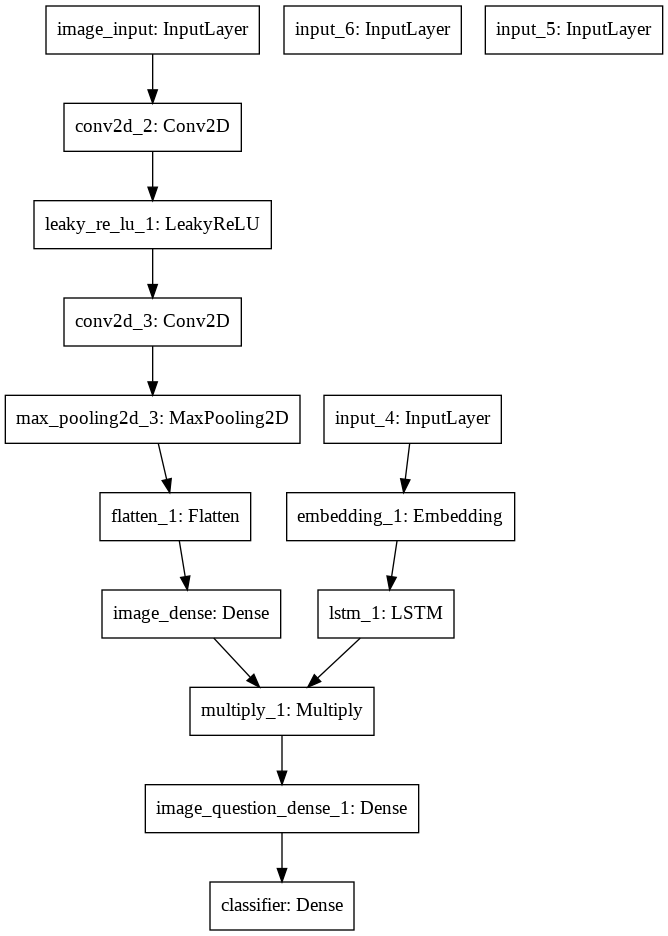

In [ ]:
plot_model(student_model, to_file='plot_model.png', show_shapes=False, show_layer_names=True)

In [ ]:
# Distill teacher to student
print(student_model.summary())
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data.take(1000),
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "student_distill_1605480942"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 112, 112, 16) 448         image_input[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 112, 112, 16) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 56, 56, 32)   4640        leaky_re_lu_3[0][0]              
_________________________________________________________________________

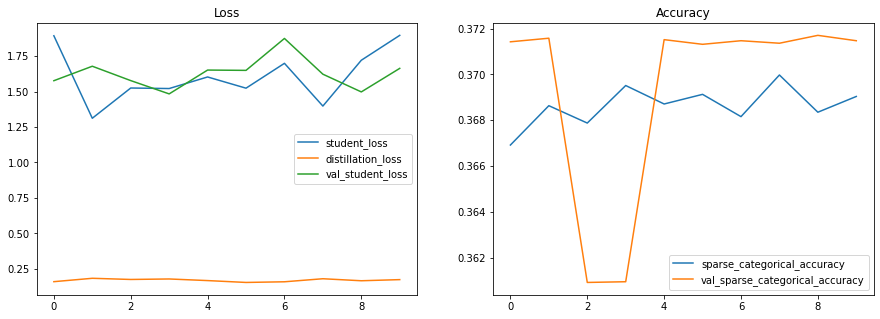

1721/1721 [==============================] - 116s 67ms/step - sparse_categorical_accuracy: 0.3699 - student_loss: 1.6241
{'sparse_categorical_accuracy': 0.36989811062812805, 'student_loss': 1.6650769710540771}


In [ ]:
evaluation_results = evaluate_model(distiller_model,validation_data, 
               training_results,execution_time, 
               learning_rate, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

In [ ]:
save_model(student_model,training_results,execution_time,learning_rate, epochs, optimizer, evaluation_results)

In [ ]:
def get_model_size(path="/content/gdrive/My Drive/models/",model_name="model01"):
  #print(os.stat(os.path.join(path,model_name+".h5")))
  model_size = os.stat(os.path.join(path,model_name+".h5")).st_size
  return model_size

In [ ]:
teacher_size = get_model_size(model_name = 'Vqa_model_test')
distilled_size = get_model_size(model_name = 'distiller_2')

In [ ]:
print(f'The teacher model size is {teacher_size}')
print(f'The distilled model size is {distilled_size}')

The teacher model size is 512490624
The distilled model size is 571604312


The number of total parameters is 14,775,626 for distilled model and 128,002,218 for the teacher model.

## **Pruning**

First, we only prune the Conv2D layers in the mobilenet part.

In [ ]:
epochs=2
learning_rate=0.001
## QA Model
max_len = 100
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
image_input = layers.Input(shape=[224,224,3], name='image_input')

#question model: BERT
encoder = TFBertModel.from_pretrained("bert-base-uncased")
encoder.trainable=False
embedding = encoder(
    input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
)[1]
embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
text_dropout=layers.Dropout(0.2)(embedding_flatten)
bert_dense = layers.Dense(256, name="bert_dense")(text_dropout)

end_step = np.ceil(len(train_x) / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

def apply_pruning_to_conv2d(layer):
  if isinstance(layer, tf.keras.layers.Conv2D):
    return tfmot.sparsity.keras.prune_low_magnitude(layer,**pruning_params)
  return layer

#image model: mobilenet
mobilenetv2_2 = MobileNetV2(include_top=False, weights='imagenet')
mobilenetv2.trainable=False
mobile_for_pruning = tf.keras.models.clone_model(
    mobilenetv2_2,
    clone_function=apply_pruning_to_conv2d,
)

image_flat = layers.Flatten()(mobile_for_pruning(image_input))
image_dropout=layers.Dropout(0.2)(image_flat)
#image_flat = Flatten()(model.layers[-1].output)(image_pretrained)
image_dense = layers.Dense(256, activation='relu')(image_dropout)

#image + question
image_question = layers.Multiply()([bert_dense, image_dense])                          
image_question_dense_1 = layers.Dense(units=32, name = 'image_question_dense_1')(image_question)
classifier = layers.Dense(units= 10, name = 'classifier')(image_question_dense_1)


inputs = (image_input, {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})

model_prune = keras.Model(inputs= inputs, outputs= classifier,name='Vqa_model_test_prune')

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate, epsilon=1e-08)

# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

model_prune.compile(optimizer=optimizer, loss=loss, metrics=[metrics.SparseCategoricalAccuracy()])

model_prune.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "Vqa_model_test_prune"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
______

In [ ]:

# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()
training_results_prune = model_prune.fit(
        train_data,
        validation_data=validation_data.take(1000),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/2
3569/3569 [==============================] - 2506s 702ms/step - loss: 1.1462 - sparse_categorical_accuracy: 0.4295 - val_loss: 1.1142 - val_sparse_categorical_accuracy: 0.4330
Epoch 2/2
3569/3569 [==============================] - 2496s 699ms/step - loss: 1.0370 - sparse_categorical_accuracy: 0.4393 - val_loss: 0.9101 - val_sparse_categorical_accuracy: 0.4615
Training execution time (mins) 83.93336793979009


In [ ]:
model_prune.evaluate(validation_data, return_dict = True)

1721/1721 [==============================] - 553s 321ms/step - loss: 0.9090 - sparse_categorical_accuracy: 0.4600


{'loss': 0.9090297222137451, 'sparse_categorical_accuracy': 0.4600294232368469}

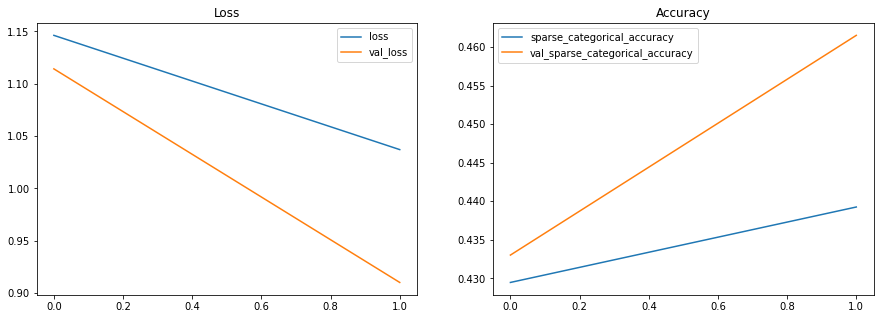

1721/1721 [==============================] - 551s 320ms/step - loss: 0.9090 - sparse_categorical_accuracy: 0.4600
{'loss': 0.9090306758880615, 'sparse_categorical_accuracy': 0.4600294232368469}


[0.9090306758880615, 0.4600294232368469]

In [ ]:
evaluate_model(model_prune,validation_data, training_results_prune,execution_time, 
               learning_rate, epochs, optimizer,save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

In [ ]:
def check_model_weights(model):
  for i, w in enumerate(model.get_weights()):
    print(model.weights[i].name,"Total:",w.size, "Zeros:", round(np.sum(w == 0) / w.size * 100,2),"%")

def compare_model_sizes(path):
    _, zip3 = tempfile.mkstemp(".zip")
    with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
        f.write(path)
    print("Model before zipping: %.2f Kb"% (os.path.getsize(path) / float(1000)))
    print("Model after zipping: %.2f Kb"% (os.path.getsize(zip3) / float(1000)))


In [ ]:
compare_model_sizes('/content/gdrive/My Drive/models/Vqa_model_test.h5')

Model before zipping: 512490.62 Kb
Model after zipping: 474306.05 Kb


In [ ]:
compare_model_sizes('/content/gdrive/My Drive/models/Vqa_model_test_prune.h5')

Model before zipping: 521100.04 Kb
Model after zipping: 472016.47 Kb


And we also prune for the whole mobilenet, not only Conv2D layers.

In [ ]:

learning_rate=0.001
## QA Model
max_len = 100
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
image_input = layers.Input(shape=[224,224,3], name='image_input')


def apply_pruning(layer):
    return tfmot.sparsity.keras.prune_low_magnitude(layer)
#question model: BERT
encoder = TFBertModel.from_pretrained("bert-base-uncased")
encoder.trainable=False
embedding = encoder(
    input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
)[1]
embedding_flatten = layers.Flatten(name="embedding_flatten")(embedding)
text_dropout=layers.Dropout(0.2)(embedding_flatten)
bert_dense = layers.Dense(256, name="bert_dense")(text_dropout)

end_step = np.ceil(len(train_x) / batch_size).astype(np.int32) * epochs
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}



#image model: mobilenet
mobilenetv2_2 = MobileNetV2(include_top=False, weights='imagenet')
mobilenetv2.trainable=False
mobile_for_pruning = tf.keras.models.clone_model(
    mobilenetv2_2,
    clone_function=apply_pruning,
)

image_flat = layers.Flatten()(mobile_for_pruning(image_input))
image_dropout=layers.Dropout(0.2)(image_flat)
#image_flat = Flatten()(model.layers[-1].output)(image_pretrained)
image_dense = layers.Dense(256, activation='relu')(image_dropout)

#image + question
image_question = layers.Multiply()([bert_dense, image_dense])                          
image_question_dense_1 = layers.Dense(units=32, name = 'image_question_dense_1')(image_question)
classifier = layers.Dense(units= 10, name = 'classifier')(image_question_dense_1)


inputs = (image_input, {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})

model_prune = keras.Model(inputs= inputs, outputs= classifier,name='Vqa_model_test_prune_all')

# Optimizer
optimizer = optimizers.Adam(lr=learning_rate, epsilon=1e-08)

# Loss
loss = losses.SparseCategoricalCrossentropy(from_logits=True)

model_prune.compile(optimizer=optimizer, loss=loss, metrics=[metrics.SparseCategoricalAccuracy()])

model_prune.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "Vqa_model_test_prune_all"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
___________________________________________________________________________

In [ ]:
epochs=2
# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()
training_results_prune = model_prune.fit(
        train_data,
        validation_data=validation_data.take(1000),
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/2
3569/3569 [==============================] - 2583s 724ms/step - loss: 1.1452 - sparse_categorical_accuracy: 0.4273 - val_loss: 0.9133 - val_sparse_categorical_accuracy: 0.4575
Epoch 2/2
3569/3569 [==============================] - 2580s 723ms/step - loss: 1.0274 - sparse_categorical_accuracy: 0.4398 - val_loss: 1.0167 - val_sparse_categorical_accuracy: 0.4419
Training execution time (mins) 86.63014124234518


In [ ]:
model_prune.evaluate(validation_data, return_dict = True)

1721/1721 [==============================] - 551s 320ms/step - loss: 1.0177 - sparse_categorical_accuracy: 0.4443


{'loss': 1.017687201499939, 'sparse_categorical_accuracy': 0.44425371289253235}

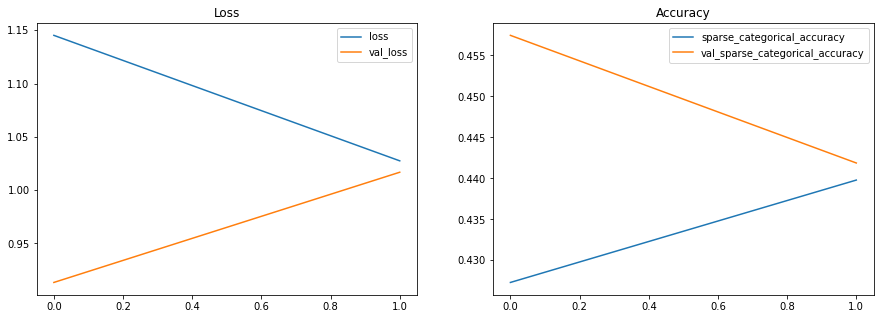

1721/1721 [==============================] - 552s 321ms/step - loss: 1.0177 - sparse_categorical_accuracy: 0.4443
{'loss': 1.0176862478256226, 'sparse_categorical_accuracy': 0.44425371289253235}


[1.0176862478256226, 0.44425371289253235]

In [ ]:
evaluate_model(model_prune,validation_data, training_results_prune,execution_time, 
               learning_rate, epochs, optimizer,save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["sparse_categorical_accuracy","val_sparse_categorical_accuracy"])

In [ ]:
compare_model_sizes('/content/gdrive/My Drive/models/Vqa_model_test_prune_all.h5')

Model before zipping: 521257.55 Kb
Model after zipping: 471959.20 Kb


In [ ]:
model_names=['Before pruning', 'Only Conv2D pruning','Mobilenet pruning']
evaltime_prune=[561,553,551]
accu_prune=[0.47118231654167175,0.4600294232368469,0.44425371289253235]
size_prune=[474306.05,472016.47,471959.20]
df_summary=pd.DataFrame({'Model':model_names,'Model Size (kb)':size_prune,'Model Accuracy':accu_prune,'Inference Time (s)':evaltime_prune})
df_summary

,Model,Model Size (kb),Model Accuracy,Inference Time (s)
0,Before pruning,474306.05,0.471182,561
1,Only Conv2D pruning,472016.47,0.460029,553
2,Mobilenet pruning,471959.20,0.444254,551


We can see the pruning doesn't quite decrease model size or inference time. The reason could be mobilenet is relatively optimized and further pruning doesn't yeild much gains.